# Getting data

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import os
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

In [2]:
def read_data(filename):
    data = pd.read_csv('../data/' + filename)
    return data[['x', 'y']], pd.Series([1 if c == 'P' else -1 for c in data['class']])

## Plotting function

In [3]:
def get_colors(v):
    return ['g' if y == 1 else 'r' for y in v]

def draw_graphics(X, y, classifier, filename, step):    
    X = X.values.tolist()
    y = y.tolist()
    plt.scatter([x[0] for x in X], [x[1] for x in X], c=get_colors(y), s=20)
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    points_count = 100
    background_X_x, background_X_y = np.meshgrid(
        np.linspace(xlim[0], xlim[1], points_count),
        np.linspace(ylim[0], ylim[1], points_count))
    
    background_Y = [classifier.predict(pd.DataFrame(np.array([[xx, xy]]), columns = ['a', 'b'])) for xx, xy in zip(background_X_x.ravel(), background_X_y.ravel())]
    plt.scatter(background_X_x, background_X_y, c=get_colors(background_Y), s=1, alpha=0.4)
    plt.xlabel('{0} dataset. {1} iterations passed'.format(filename, str(step)))
    plt.show()


In [4]:
def plot_train_test_accuracy(train_accuracy, test_accuracy):
    plt.plot(range(1, len(train_accuracy) + 1), test_accuracy, color='orange', label='test')
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, color='darkblue', label='train')
    plt.xlabel('Iterations count')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## AdaBoost

In [5]:
class AdaBoostClassifier:
    def __init__(self):
        self.classifiers = []
        self.alphas = []
        self.weights = None

    def fit_one(self, X, y):
        if self.weights is None:
            self.weights = [1.0 / len(X)] * len(X)

        classifier = DecisionTreeClassifier()
        indices = random.choices(range(len(X)), weights=self.weights, k=len(X))
        bootstrap_X = X.iloc[indices]
        bootstrap_Y = y.iloc[indices]
        classifier.fit(bootstrap_X, bootstrap_Y)

        y_pred = classifier.predict(X)
        
        error = sum([self.weights[i] for i in range(len(X)) if y_pred[i] != y.iloc[i]])
        alpha = 0.5 * np.log((1 - error) / error) if np.isclose(0, error) else 1

        self.weights = [self.weights[i] * np.exp(-alpha * y.iloc[i] * y_pred[i]) for i in range(len(self.weights))]

        z = sum(self.weights)
        self.weights = [w / z for w in self.weights]

        self.classifiers.append(classifier)
        self.alphas.append(alpha)
        
    def predict(self, X):
        return np.sign(sum([self.alphas[i] * self.classifiers[i].predict(X) for i in range(len(self.classifiers))]))

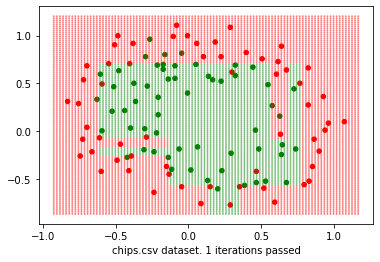

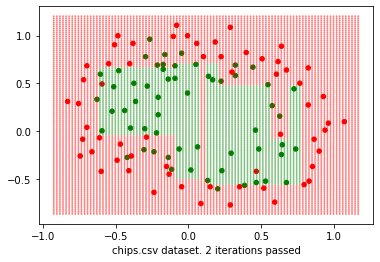

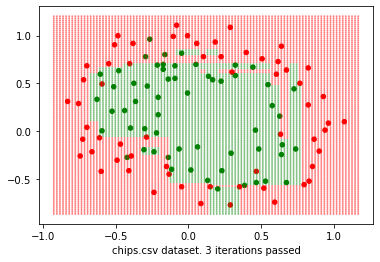

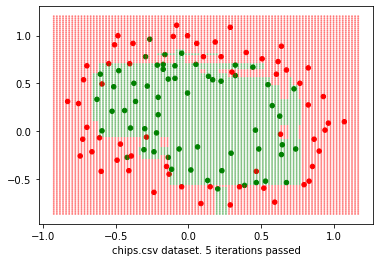

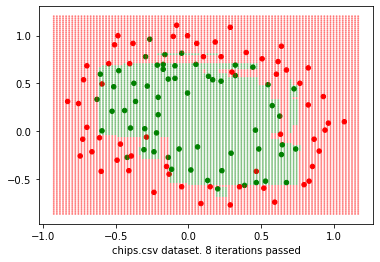

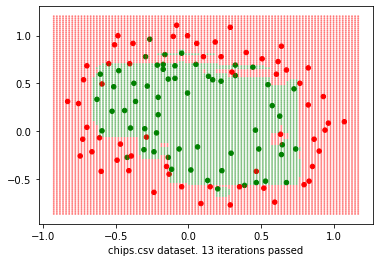

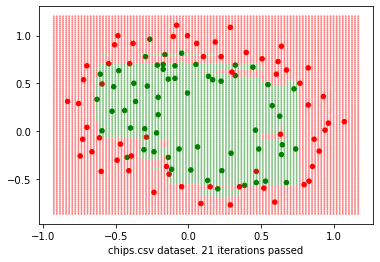

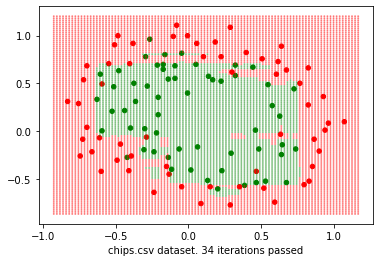

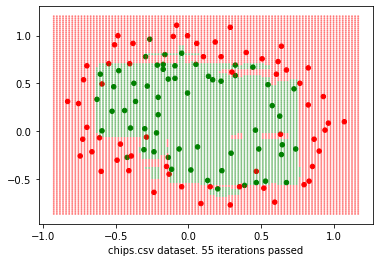

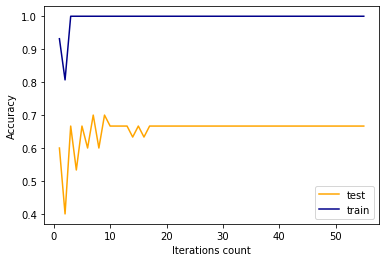

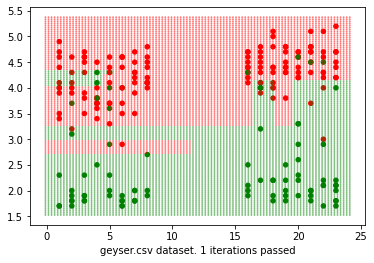

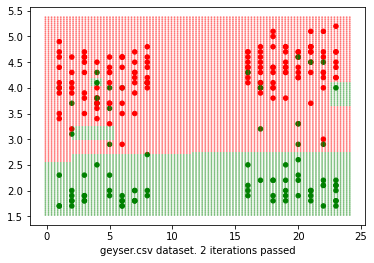

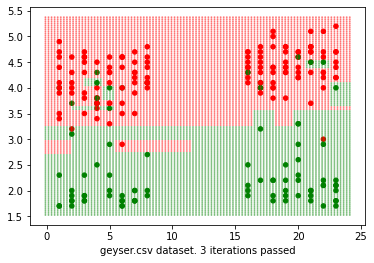

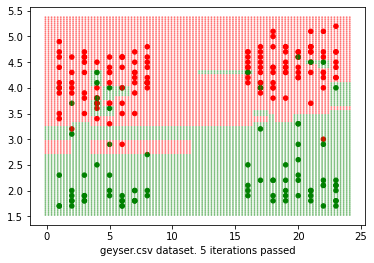

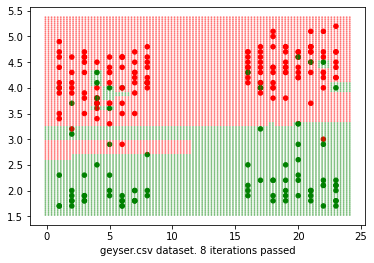

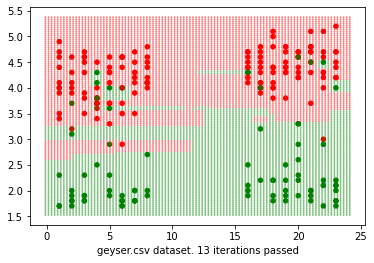

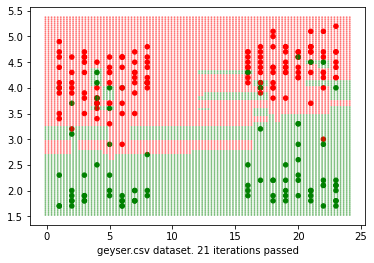

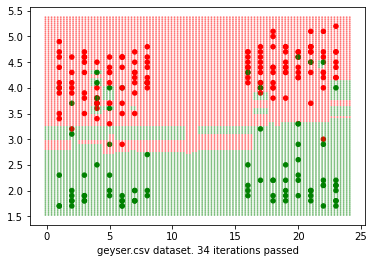

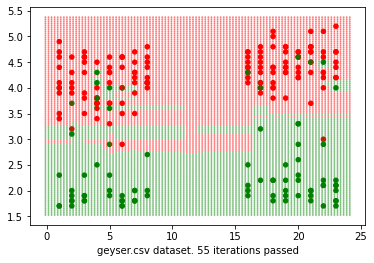

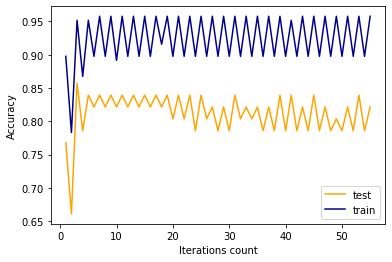

In [6]:
plotting_steps = [1, 2, 3, 5, 8, 13, 21, 34, 55]
for filename in os.listdir('../data'):
    X, y = read_data(filename)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    train_scores = []
    test_scores = []
    steps = 55
    classifier = AdaBoostClassifier()
    for step in tqdm(range(1, steps + 1)):
        classifier.fit_one(X_train, y_train)
        train_scores.append(accuracy_score(classifier.predict(X_train), y_train))
        test_scores.append(accuracy_score(classifier.predict(X_test), y_test))
        if step in plotting_steps:
            draw_graphics(X, y, classifier, filename, step)
    plot_train_test_accuracy(train_scores, test_scores)
    